In [1]:
from global_vars import *
from transformers import AutoModelForMultipleChoice, AutoTokenizer
from datasets import Dataset, load_from_disk
from tqdm import tqdm
import pandas as pd
import wandb
import pickle
import numpy as np

import tensorflow as tf
import os
from tensorflow.keras import Model # if only machine learning were this easy :P
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import any other libraries you want here:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, SpatialDropout1D, LSTM, Embedding
from tensorflow.keras.activations import softmax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("converted_new_for_custom.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106067 entries, 0 to 106066
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   posts    106067 non-null  object
 1   type     106067 non-null  object
 2   new_col  106067 non-null  int64 
 3   pad      106067 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.2+ MB


In [3]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['posts'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 256681 unique tokens.


In [4]:
X = tokenizer.texts_to_sequences(df['posts'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (106067, 500)


In [5]:
Y = pd.get_dummies(df['type']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (106067, 16)


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(95460, 500) (95460, 16)
(10607, 500) (10607, 16)


In [8]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 1
batch_size = 128

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 500, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 16)                1616      
                                                                 
Total params: 5,082,016
Trainable params: 5,082,016
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

  2/672 [..............................] - ETA: 23:07 - loss: 2.7712 - accuracy: 0.0859

KeyboardInterrupt: 

In [12]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

 67/332 [=====>........................] - ETA: 24s - loss: 2.7720 - accuracy: 0.0667

KeyboardInterrupt: 

NameError: name 'history' is not defined

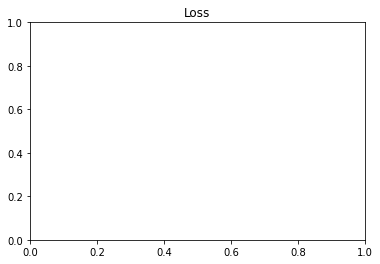

In [11]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

NameError: name 'history' is not defined

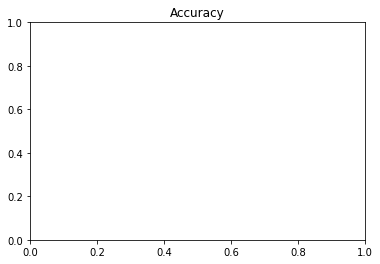

In [10]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [9]:
!mkdir -p saved_model
model.save('saved_model/my_model')


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets
